In [632]:
import numpy as np
import pandas as pd
import math
import sys, os
import mplcyberpunk
import matplotlib.pyplot as plt
from matplotlib.colors import hex2color, to_hex
import matplotlib.colors as mc
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve, auc, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

import xgboost as xgb

plt.style.use("cyberpunk")

In [633]:
train_time = 1 * 60 * 60
objective = 'xgbhandregressor'

In [634]:
sys.path.append(os.path.realpath('..'))

In [635]:
train_df = pd.read_csv(r"..\data\train.csv", index_col=0)
test_df = pd.read_csv(r"..\data\test.csv", index_col=0)
sample_sub = pd.read_csv(r"..\data\sample_submission.csv", index_col=0)

In [636]:
target = ['quality']
columns = train_df.columns.to_list()
columns.remove(target[0])
features = columns

# Rendering

In [637]:
plt.style.use("cyberpunk")

def render_xgb_features(model):
    histplot_hyperparams = {
            'alpha':0.4,
            #'stat':'percent',
            #'bins':100
            #'kde':True,
        }

    n_cols = 1
    n_rows = 1
    cell_with_dim = 20
    cell_height_dim = 5

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))

    fi_df = pd.DataFrame([model.feature_importances_], columns=train_df[features].columns)
    sns.barplot(fi_df.T.reset_index(), x='index', y=0,ax=ax, label=features, **histplot_hyperparams)
    #sns.histplot(train_df[target], ax=ax, **histplot_hyperparams)

    mplcyberpunk.make_lines_glow(ax)
    plt.show()

In [638]:
from itertools import islice, cycle
from cycler import cycler

plt.style.use("cyberpunk")

mplcyberpunk.cyberpunk_stylesheets['cyberpunk']['axes.prop_cycle'] = cycler('color', ['#08F7FE', '#FE53BB', '#F5D300', '#00ff41', 'r', '#fe00fe', '#FF5733'])

def add_secondary_plot(df, column, target_column, ax, n_bins, color=3, show_yticks=False, marker="."):
    secondary_ax = ax.twinx()
    bins = pd.cut(df[column], bins=n_bins)
    bins = pd.IntervalIndex(bins)
    bins = (bins.left + bins.right) / 2
    target = df.groupby(bins)[target_column].mean()
    target.plot(
        ax=secondary_ax, linestyle='',
        marker=marker, color=color, label=f"Mean '{target_column}'"
    )
    secondary_ax.grid(visible=False)
    
    if not show_yticks:
        secondary_ax.get_yaxis().set_ticks([])
        
    return secondary_ax

def render_feature_distros(train_df, test_df, features=[], labels=[], n_bins=50, n_cols=4, pad=2, h_pad=4, w_pad=None, boarders=None):
    if boarders is not None:
        factor=1.0/max(boarders.values())
        for k in boarders:
            boarders[k] = boarders[k]*factor  
    
    histplot_hyperparams = {
        'kde':True,
        'alpha':0.4,
        'stat':'percent',
        'bins':n_bins
    }
    markers = ['.', '+', 'x', '1', '2']
    
    n_rows = math.ceil(len(features) / n_cols)
    cell_with_dim = 4
    cell_height_dim = 3
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))
    plt.tight_layout(pad=pad, h_pad=h_pad, w_pad=w_pad, rect=None)
    
    # delete exess subplots
    for a in ax[n_rows - 1, int(((n_rows - (len(features) + 1 / n_cols)) * n_cols*-1)):]:
        a.axis('off')
        print('off')
        
    leg_handles = []
    leg_labels = []
    
    axs = []
    
    hc = ['r', 'y', 'g']
    th = [0, 0.5, 1]

    cdict = NonLinCdict(th, hc)
    colormap = mc.LinearSegmentedColormap('test', cdict)
 

    for i, feature in enumerate(features):
        row = math.ceil(i / n_cols) - 1
        col = (i % n_cols)
        
        color_cycle = islice(mplcyberpunk.cyberpunk_stylesheets['cyberpunk']['axes.prop_cycle'], 0, None)
        
        sns.histplot(train_df[feature], label='Train X', ax=ax[row, col], color=next(color_cycle)['color'], **histplot_hyperparams)
        sns.histplot(test_df[feature], label='Test X', ax=ax[row, col],color=next(color_cycle)['color'], **histplot_hyperparams)
        ax[row, col].set_title(f'{feature} Distribution')
        
        if boarders is not None:
            c = to_hex(list(colormap(boarders[feature])))
            print(f'feature:{feature} color{c} row:{row} col{col}')
            linewidth = 2
            ax[row, col].spines['bottom'].set_color(c)
            ax[row, col].spines['bottom'].set_linewidth(linewidth)
            ax[row, col].spines['top'].set_color(c)
            ax[row, col].spines['top'].set_linewidth(linewidth)
            ax[row, col].spines['left'].set_color(c)
            ax[row, col].spines['left'].set_linewidth(linewidth)
            ax[row, col].spines['right'].set_color(c)
            ax[row, col].spines['right'].set_linewidth(linewidth)
            #ax[row, col].patch.set_linewidth('1')  
        
        mplcyberpunk.make_lines_glow(ax[row, col])
        axs.append(ax[row, col].get_legend_handles_labels())

        for j, label in enumerate(labels):
            sub_ax = add_secondary_plot(train_df, feature, label, ax[row, col], n_bins, color=next(color_cycle)['color'], marker=markers[j])
            axs.append(sub_ax.get_legend_handles_labels())
        
    for axis in axs:
        if axis[1][0] not in leg_labels:
            leg_labels.extend(axis[1])
            leg_handles.extend(axis[0])
        
    fig.legend(leg_handles, leg_labels, loc='upper center', bbox_to_anchor=(0.5, 1.04), fontsize=14, ncol=len(features) + 2)

In [639]:
def NonLinCdict(steps, hexcol_array):
    cdict = {'red': (), 'green': (), 'blue': ()}
    for s, hexcol in zip(steps, hexcol_array):
        rgb = hex2color(hexcol)
        cdict['red'] = cdict['red'] + ((s, rgb[0], rgb[0]),)
        cdict['green'] = cdict['green'] + ((s, rgb[1], rgb[1]),)
        cdict['blue'] = cdict['blue'] + ((s, rgb[2], rgb[2]),)
    return cdict

def render_cm(matrix):

    hc = ['#212946', '#FE53BB', '#F5D300']
    th = [0, 0.5, 1]

    cdict = NonLinCdict(th, hc)
    colormap = mc.LinearSegmentedColormap('test', cdict)


    fig, ax = plt.subplots(1, figsize=(10,10))
    plt.title('Confusion Matrix', y=1.08, fontsize = 20)
    res = sns.heatmap(matrix, annot=True, cmap=colormap, ax = ax, fmt='.2f')
    for _, spine in res.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_color('#08F7FE')

    xticks = ax.get_xticks()
    for i in range(len(xticks)-1):  
        ax.axvline( x=(xticks[i] + xticks[i+1]) / 2, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linewidth=0.5, color='#08F7FE')

    yticks = ax.get_yticks()
    for i in range(len(yticks)-1):  
        ax.axhline( y=(yticks[i] + yticks[i+1]) / 2, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linewidth=0.5, color='#08F7FE')


    # plt.savefig("Heatmap.png")
    mplcyberpunk.make_lines_glow(ax, diff_linewidth=0.9)
    plt.show()

In [640]:
def feature_by_target(train_df):
    n_cols = 4
    n_rows = math.ceil(len(features) / n_cols)
    cell_with_dim = 4
    cell_height_dim = 3
    pad=2
    h_pad=4
    w_pad=None
    n_bins=50

    histplot_hyperparams = {
        'kde':True,
        'alpha':0.4,
        'stat':'percent',
        'bins':n_bins
    }

    colors = ['#08F7FE', '#FE53BB', '#F5D300', '#00ff41', 'r', '#fe00fe', '#FF5733', 'g']

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))
    plt.tight_layout(pad=pad, h_pad=h_pad, w_pad=w_pad, rect=None)

    for a in ax[n_rows - 1, int(((n_rows - (len(features) / n_cols)) * n_cols*-1)):]:
        a.axis('off')
    axs = []
    for i, feature in tqdm(enumerate(features)):
        row = math.ceil(i / n_cols) - 1
        col = (i % n_cols) 
        targets = train_df[target[0]].unique()
        for s, t in enumerate(targets):
            bp = ax[row, col].boxplot(x=train_df[train_df[target[0]] == t][feature], sym='k+', patch_artist=True, positions=[s], widths=cell_with_dim / (cell_with_dim + 2))
            c1 = colors[s]
            c2 = '#ffffff50'
            ax[row, col].set_title(feature)
            for box in bp['boxes']:
                box.set(color=c1, linewidth=1)
                box.set(facecolor=c1)
                r, g, b, a = box.get_facecolor()
                box.set_facecolor((r, g, b, .4)) # alpha layer
            for whisker in bp['whiskers']:
                whisker.set(color=c1, linewidth=1)
            for cap in bp['caps']:
                cap.set(color=c1, linewidth=1)
            for median in bp['medians']:
                median.set(color=c1)
            for flier in bp['fliers']:
                flier.set(color=c1, linewidth=1)
                flier.set(markeredgecolor=c1)

        mplcyberpunk.make_lines_glow(ax[row, col])

        axs.append(ax[row, col].get_legend_handles_labels())

# PreProcessing

In [641]:
classes = train_df[target[0]].unique()
classes

array([6, 7, 5, 4, 8, 3], dtype=int64)

In [642]:
#train_df['tick'] = 1
#train_df.groupby(target[0])['tick'].sum()

In [643]:
scrubbed_df = train_df.copy()
classes = scrubbed_df[target[0]].unique()
for spec_class in classes:
    scrubbed_df[f'bi_{spec_class}'] = 0
    scrubbed_df.loc[scrubbed_df[target[0]] == spec_class, f'bi_{spec_class}'] = 1
scrubbed_df

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
Id                                                                              
0               8.0              0.50         0.39            2.20      0.073   
1               9.3              0.30         0.73            2.30      0.092   
2               7.1              0.51         0.03            2.10      0.059   
3               8.1              0.87         0.22            2.60      0.084   
4               8.5              0.36         0.30            2.30      0.079   
...             ...               ...          ...             ...        ...   
2051            6.6              0.31         0.13            2.00      0.056   
2052            9.7              0.59         0.21            1.80      0.079   
2053            7.7              0.43         0.42            1.70      0.071   
2054            9.1              0.50         0.00            1.75      0.058   
2055            6.2              0.31         0.18            2.30      0.059   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
Id                                                                          
0                    30.0                  39.0  0.99572  3.33       0.77   
1                    30.0                  67.0  0.99854  3.32       0.67   
2                     3.0                  12.0  0.99660  3.52       0.73   
3                    11.0                  65.0  0.99730  3.20       0.53   
4                    10.0                  45.0  0.99444  3.20       1.36   
...                   ...                   ...      ...   ...        ...   
2051                 29.0                  42.0  0.99388  3.52       0.87   
2052                 27.0                  65.0  0.99745  3.14       0.58   
2053                 19.0                  37.0  0.99258  3.32       0.77   
2054                  5.0                  13.0  0.99670  3.22       0.42   
2055                 12.0                  28.0  0.99520  3.56       0.88   

      alcohol  quality  bi_6  bi_7  bi_5  bi_4  bi_8  bi_3  
Id                                                          
0        12.1        6     1     0     0     0     0     0  
1        12.8        6     1     0     0     0     0     0  
2        11.3        7     0     1     0     0     0     0  
3         9.8        5     0     0     1     0     0     0  
4         9.5        6     1     0     0     0     0     0  
...       ...      ...   ...   ...   ...   ...   ...   ...  
2051     12.0        7     0     1     0     0     0     0  
2052      9.4        5     0     0     1     0     0     0  
2053     12.5        8     0     0     0     0     1     0  
2054      9.5        5     0     0     1     0     0     0  
2055     11.4        7     0     1     0     0     0     0  

[2056 rows x 18 columns]

11it [00:00, 17.30it/s]


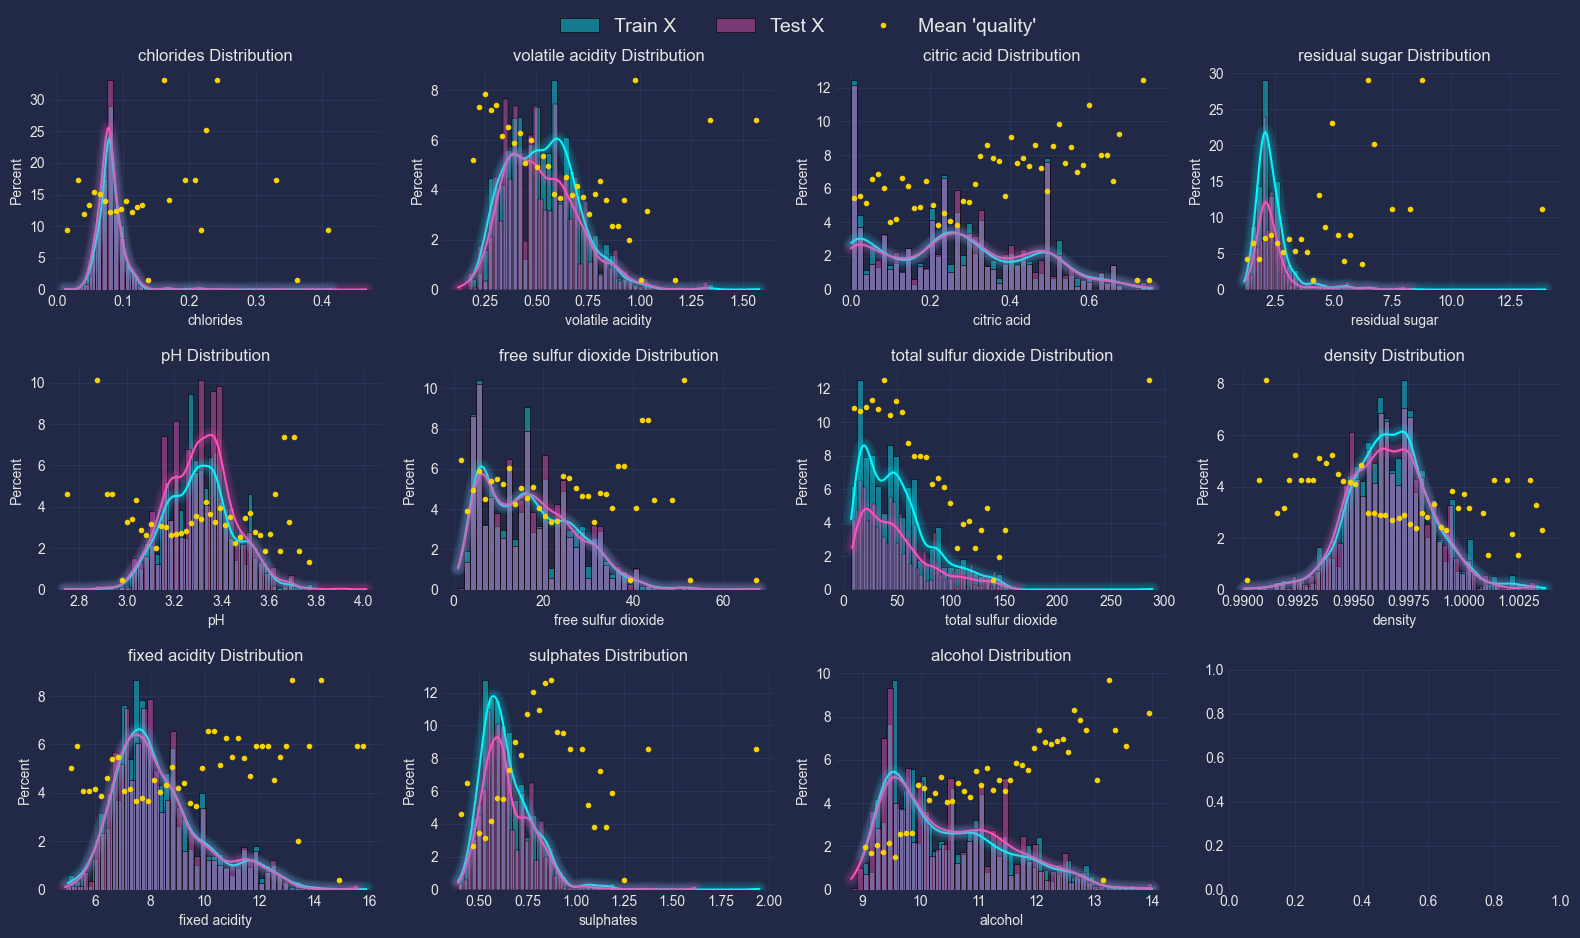

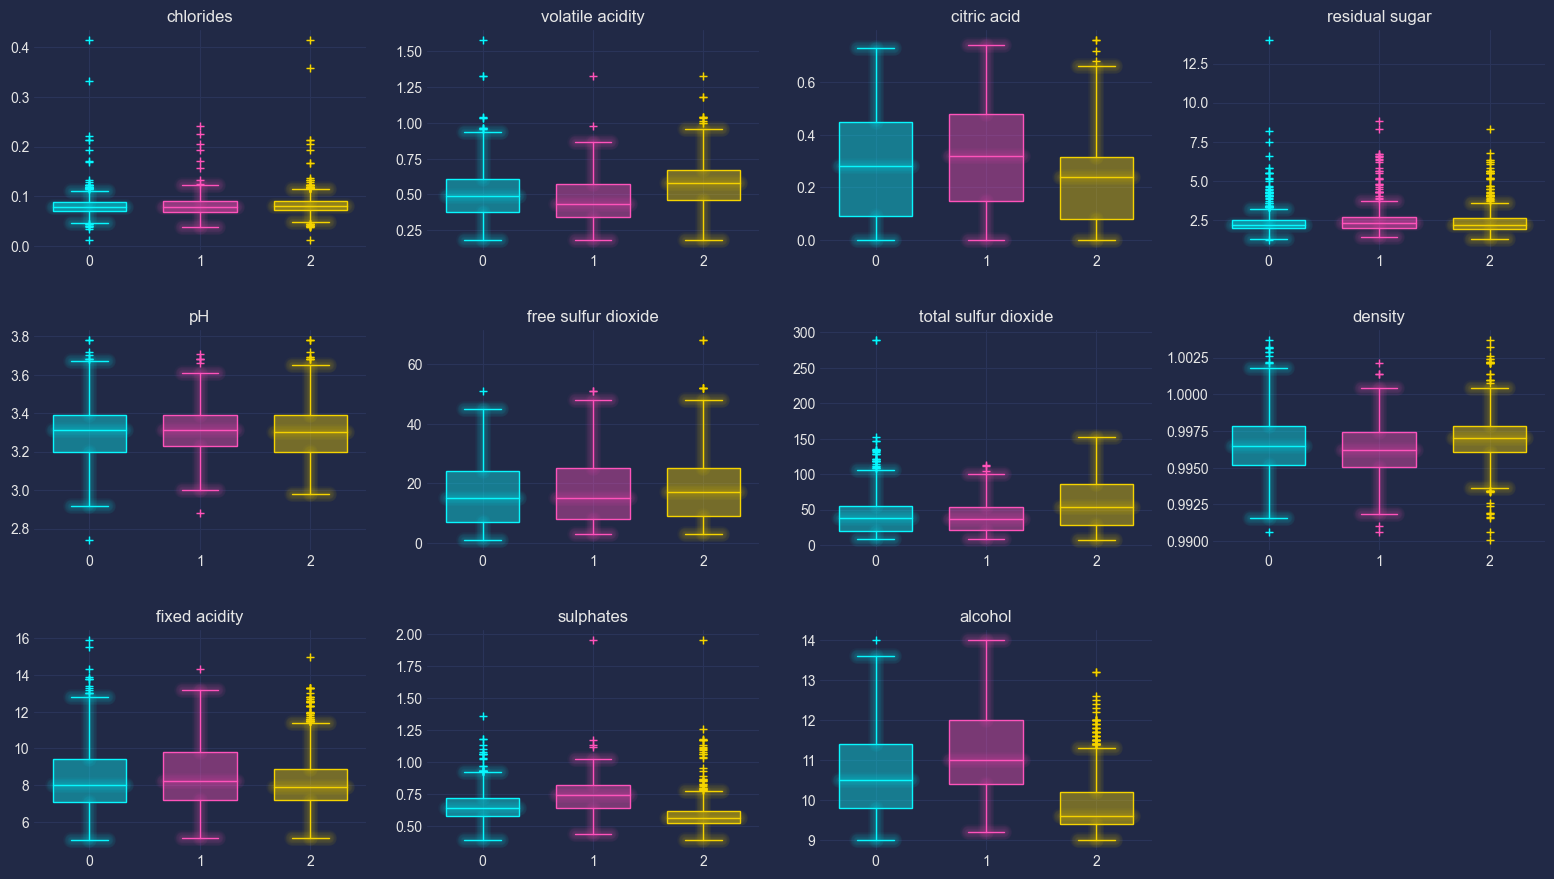

In [399]:
scrubbed_df = train_df.copy()
scrubbed_df = scrubbed_df[~scrubbed_df[target[0]].isin([3,4,8])]
render_feature_distros(train_df=scrubbed_df, test_df=test_df, features=features, labels=[target[0]])
feature_by_target(scrubbed_df)

In [363]:
train_df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'xgb_first_quality', 'tick'],
      dtype='object')

11it [00:01,  7.35it/s]


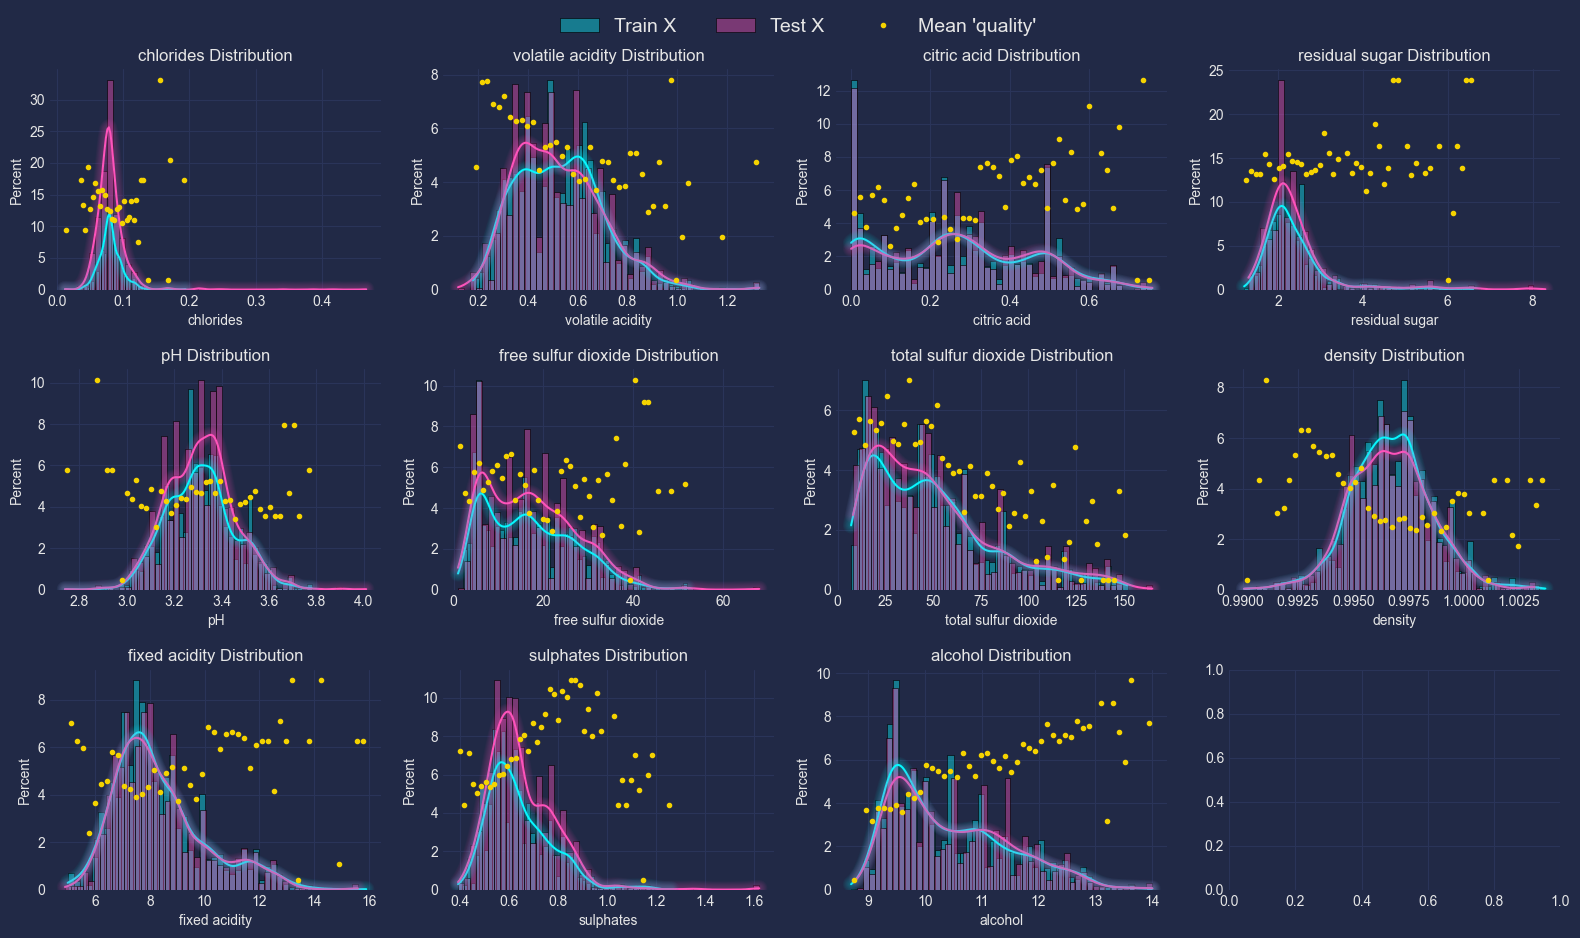

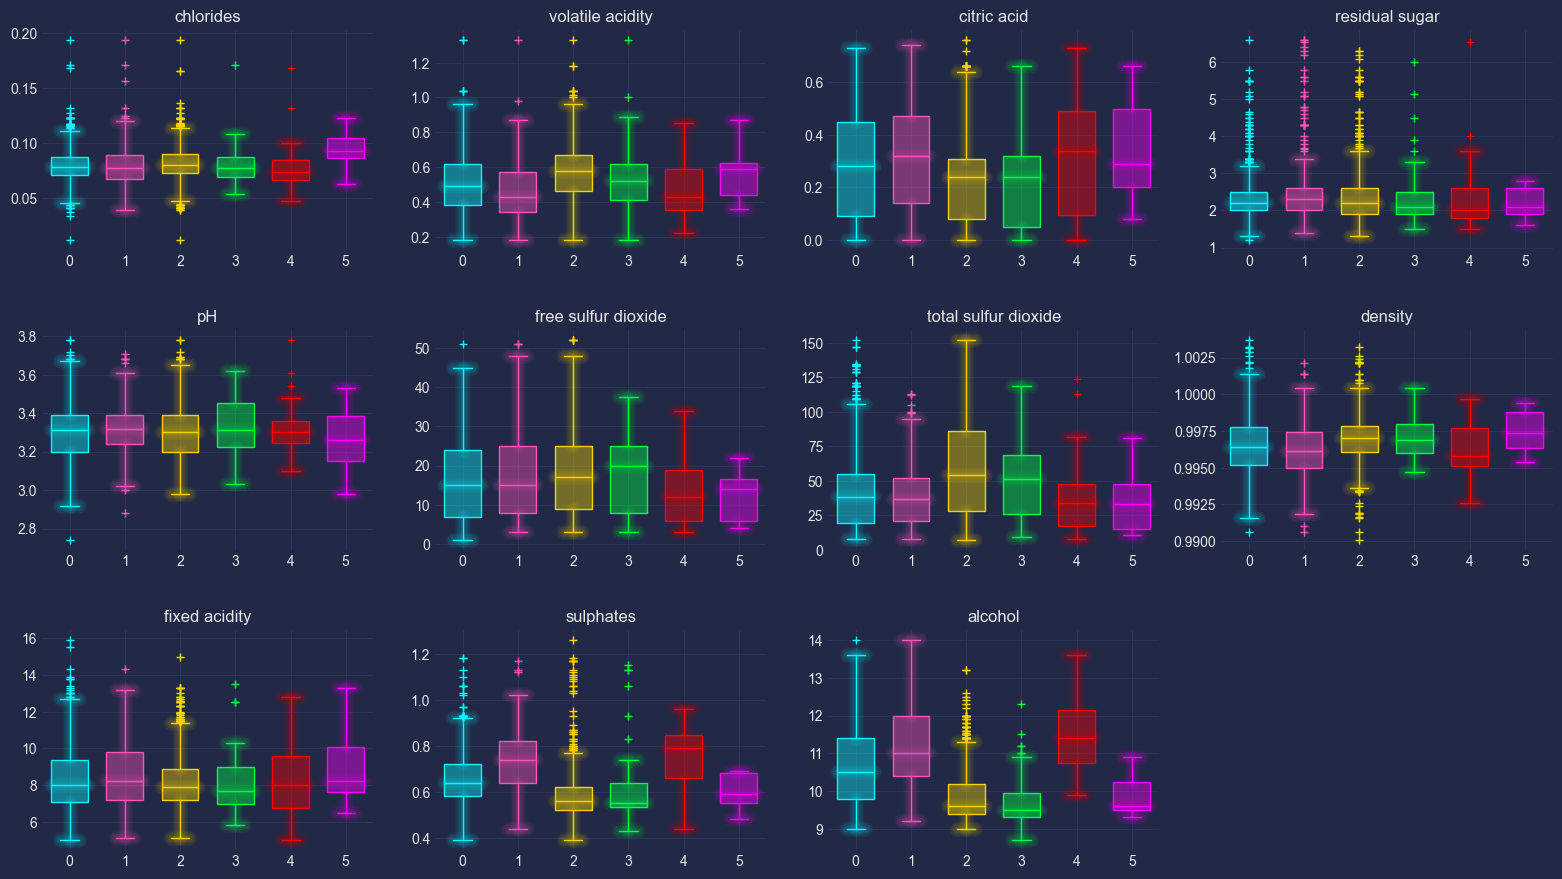

In [378]:
scrubbed_df = train_df.copy()

outlier_counter = {}
outlier_indicies = []
for feature in features:
    std = scrubbed_df[feature].std()
    mean = scrubbed_df[feature].mean()
    std_multiplier = 5
    outliers = scrubbed_df[(scrubbed_df[feature] > mean + std * std_multiplier) | (scrubbed_df[feature] < mean - std * std_multiplier)]
    outlier_counter[feature] = len(outliers)
    outlier_indicies.extend(list(outliers.index))

    scrubbed_df = scrubbed_df[~scrubbed_df.index.isin(outlier_indicies)]

render_feature_distros(train_df=scrubbed_df, test_df=test_df, features=features, labels=[target[0]])
feature_by_target(scrubbed_df)

Checkpoint Record Count after removing outliers from fixed acidity: 2056
Checkpoint Record Count after removing outliers from fixed acidity: 2056
Checkpoint Record Count after removing outliers from fixed acidity: 2056
Checkpoint Record Count after removing outliers from fixed acidity: 2056
Checkpoint Record Count after removing outliers from fixed acidity: 2056
Checkpoint Record Count after removing outliers from fixed acidity: 2056
Checkpoint Record Count after removing outliers from volatile acidity: 2056
Checkpoint Record Count after removing outliers from volatile acidity: 2056
Checkpoint Record Count after removing outliers from volatile acidity: 2056
Checkpoint Record Count after removing outliers from volatile acidity: 2056
Checkpoint Record Count after removing outliers from volatile acidity: 2056
Checkpoint Record Count after removing outliers from volatile acidity: 2056
Checkpoint Record Count after removing outliers from citric acid: 2056
Checkpoint Record Count after remov

11it [00:01,  7.23it/s]


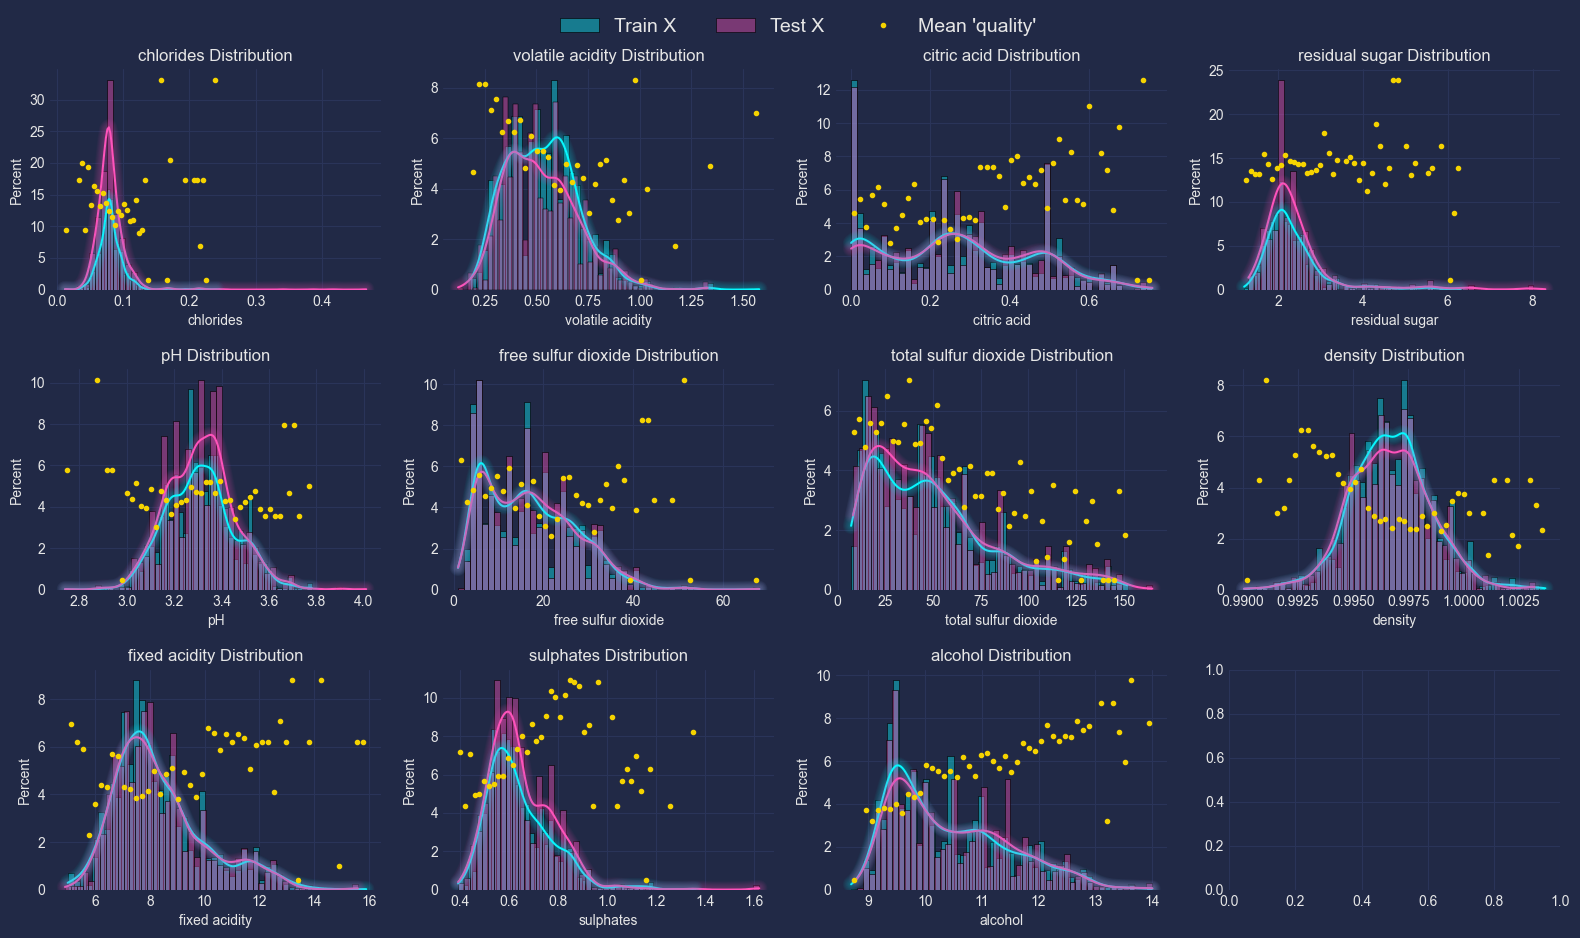

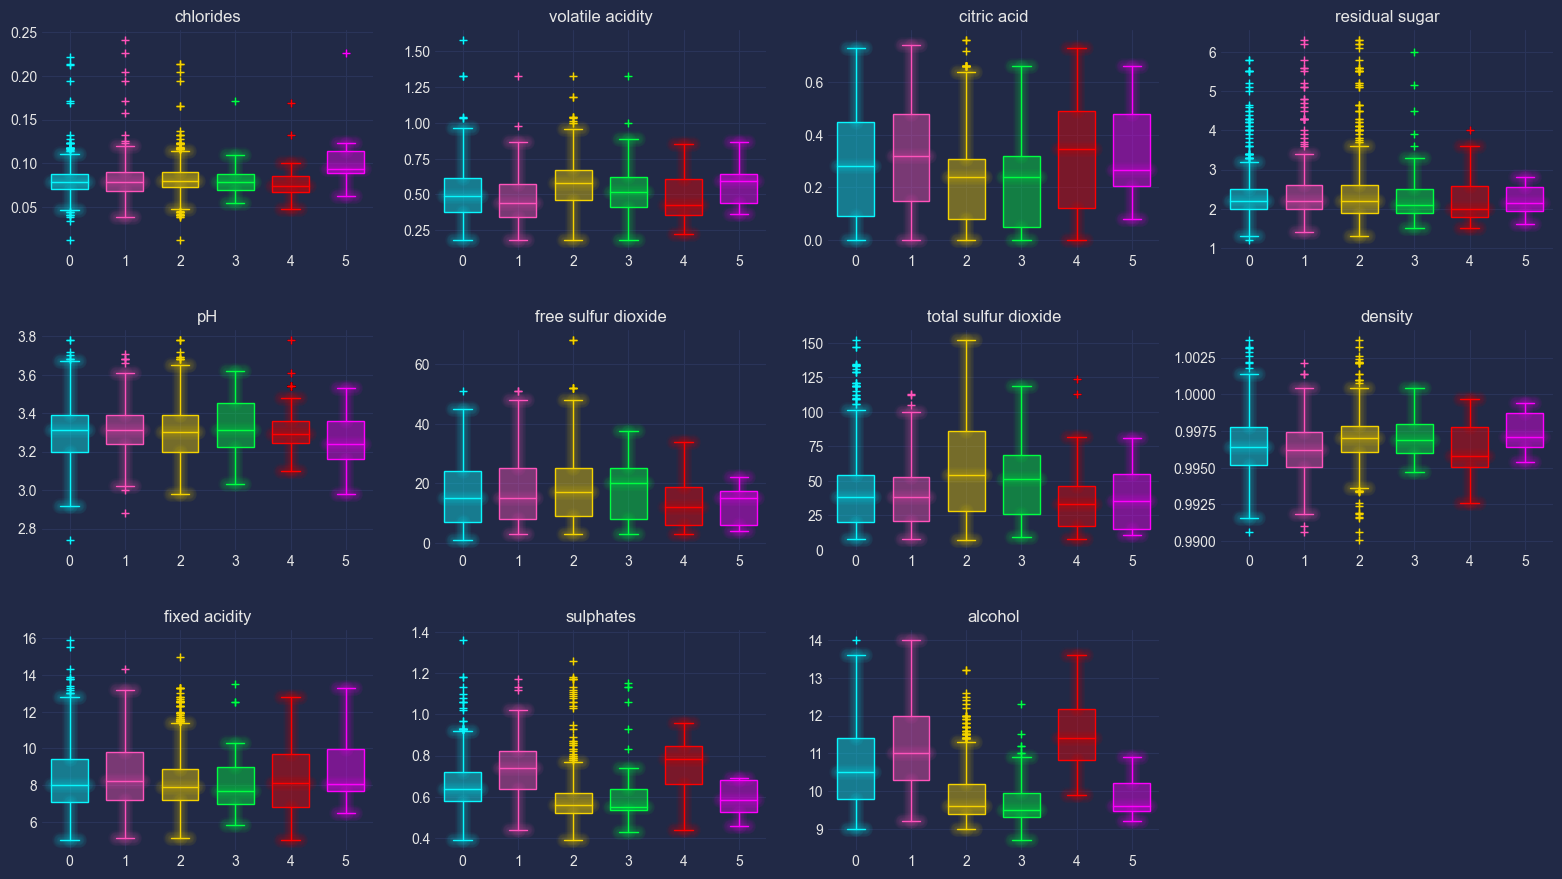

In [294]:
scrubbed_df = train_df.copy()

for feature in features:
    for specific_class in classes:
        std_multiplier = 10
        std = scrubbed_df[scrubbed_df[target[0]] == specific_class][feature].std()
        mean = scrubbed_df[scrubbed_df[target[0]] == specific_class][feature].mean()
        scrubbed_df = scrubbed_df[(scrubbed_df[feature] < mean + std*std_multiplier) & (scrubbed_df[feature] > mean - std*std_multiplier)]
        print(f'Checkpoint Record Count after removing outliers from {feature}: {len(scrubbed_df.index)}')
        
render_feature_distros(train_df=scrubbed_df, test_df=test_df, features=features, labels=[target[0]])
feature_by_target(scrubbed_df)



Starting Record Count: 2056
Checkpoint Record Count after removing outliers from sulphates: 2012
Checkpoint Record Count after removing outliers from density: 1971
Checkpoint Record Count after removing outliers from chlorides: 1968
Checkpoint Record Count after removing outliers from chlorides: 1948
Checkpoint Record Count after removing outliers from residual sugar: 1930
Checkpoint Record Count after removing outliers from residual sugar: 1908
Checkpoint Record Count after removing outliers from alcohol: 1842


11it [00:01,  6.29it/s]


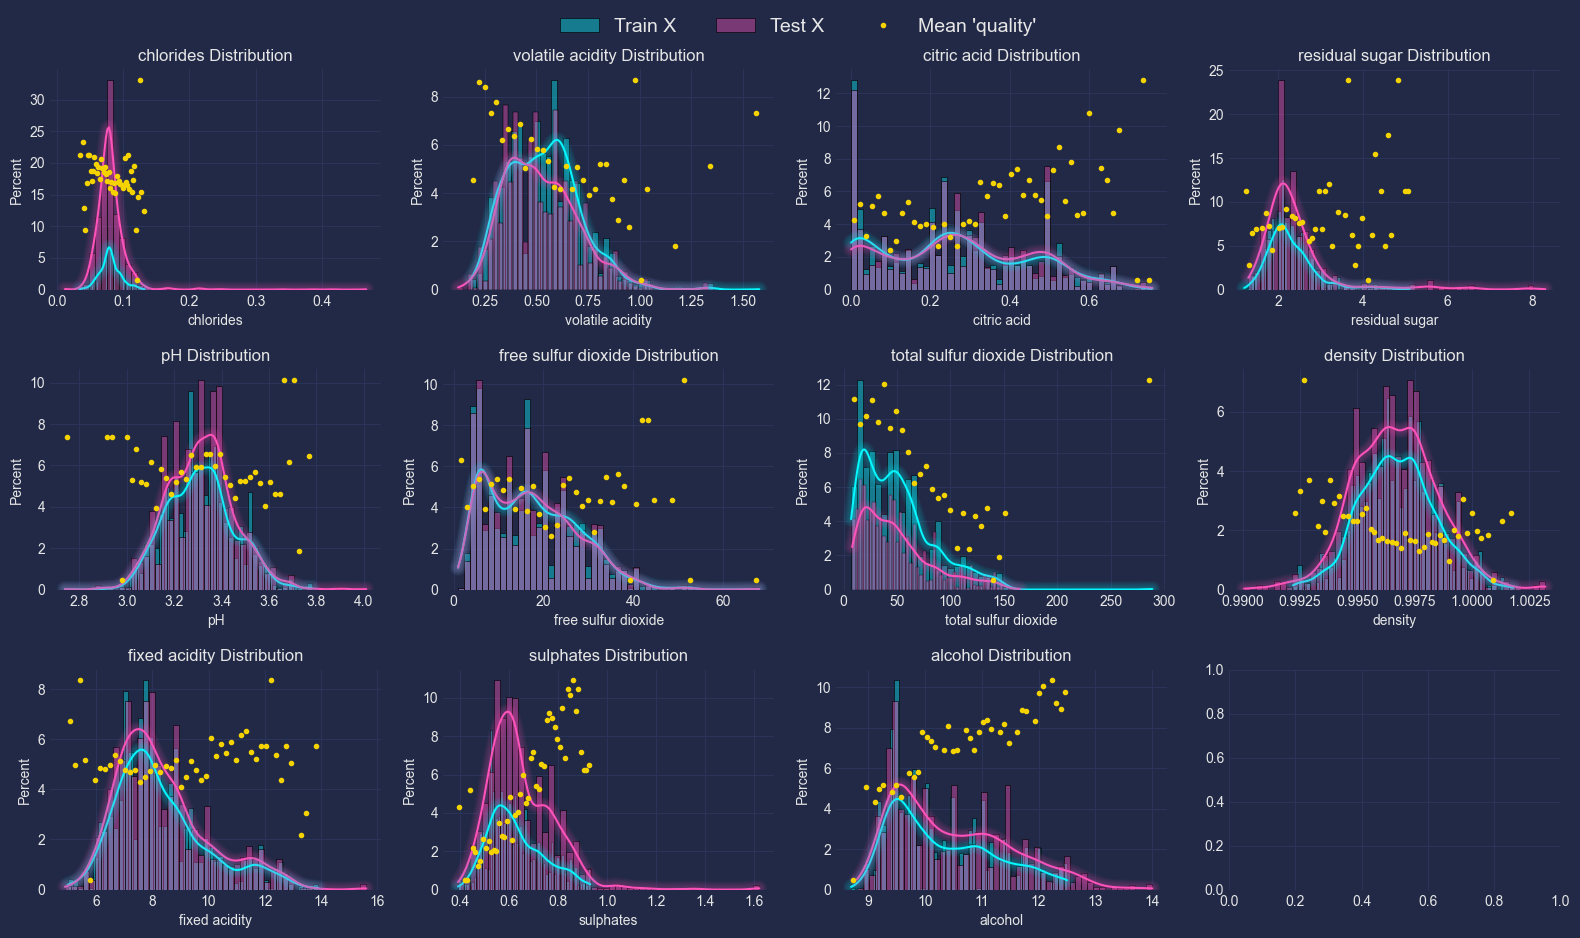

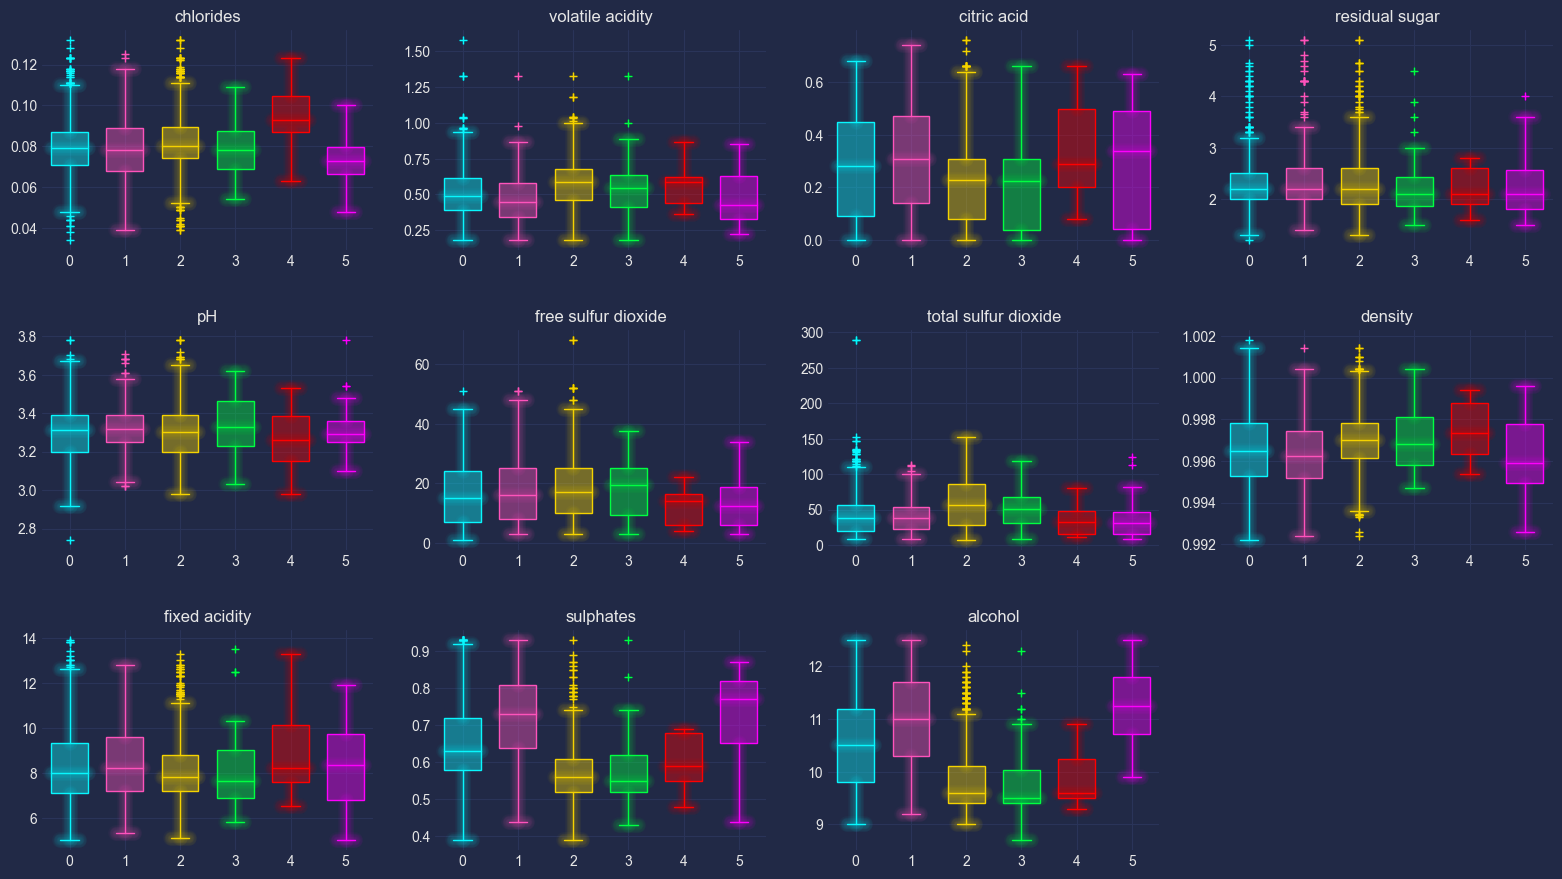

In [241]:
scrubbed_df = train_df.copy()

print(f'Starting Record Count: {len(scrubbed_df.index)}')

feature = 'sulphates'
specific_class = 2 + 3
std_multiplier = 3
std = scrubbed_df[scrubbed_df[target[0]] == specific_class][feature].std()
mean = scrubbed_df[scrubbed_df[target[0]] == specific_class][feature].mean()
scrubbed_df = scrubbed_df[(scrubbed_df[feature] < mean + std*std_multiplier) & (scrubbed_df[feature] > mean - std*std_multiplier)]
print(f'Checkpoint Record Count after removing outliers from {feature}: {len(scrubbed_df.index)}')

feature = 'density'
specific_class = 2 + 3
std_multiplier = 3
std = scrubbed_df[scrubbed_df[target[0]] == specific_class][feature].std()
mean = scrubbed_df[scrubbed_df[target[0]] == specific_class][feature].mean()
scrubbed_df = scrubbed_df[(scrubbed_df[feature] < mean + std*std_multiplier) & (scrubbed_df[feature] > mean - std*std_multiplier)]
print(f'Checkpoint Record Count after removing outliers from {feature}: {len(scrubbed_df.index)}')

feature = 'chlorides'
specific_class = 0 + 3
std_multiplier = 3
std = scrubbed_df[scrubbed_df[target[0]] == specific_class][feature].std()
mean = scrubbed_df[scrubbed_df[target[0]] == specific_class][feature].mean()
scrubbed_df = scrubbed_df[(scrubbed_df[feature] < mean + std*std_multiplier) & (scrubbed_df[feature] > mean - std*std_multiplier)]
print(f'Checkpoint Record Count after removing outliers from {feature}: {len(scrubbed_df.index)}')

feature = 'chlorides'
specific_class = 1 + 3
std_multiplier = 3
std = scrubbed_df[scrubbed_df[target[0]] == specific_class][feature].std()
mean = scrubbed_df[scrubbed_df[target[0]] == specific_class][feature].mean()
scrubbed_df = scrubbed_df[(scrubbed_df[feature] < mean + std*std_multiplier) & (scrubbed_df[feature] > mean - std*std_multiplier)]
print(f'Checkpoint Record Count after removing outliers from {feature}: {len(scrubbed_df.index)}')

feature = 'residual sugar'
specific_class = 1 + 3
std_multiplier = 4
std = scrubbed_df[scrubbed_df[target[0]] == specific_class][feature].std()
mean = scrubbed_df[scrubbed_df[target[0]] == specific_class][feature].mean()
scrubbed_df = scrubbed_df[(scrubbed_df[feature] < mean + std*std_multiplier) & (scrubbed_df[feature] > mean - std*std_multiplier)]
print(f'Checkpoint Record Count after removing outliers from {feature}: {len(scrubbed_df.index)}')

feature = 'residual sugar'
specific_class = 2 + 3
std_multiplier = 4
std = scrubbed_df[scrubbed_df[target[0]] == specific_class][feature].std()
mean = scrubbed_df[scrubbed_df[target[0]] == specific_class][feature].mean()
scrubbed_df = scrubbed_df[(scrubbed_df[feature] < mean + std*std_multiplier) & (scrubbed_df[feature] > mean - std*std_multiplier)]
print(f'Checkpoint Record Count after removing outliers from {feature}: {len(scrubbed_df.index)}')

feature = 'alcohol'
specific_class = 2 + 3
std_multiplier = 4
std = scrubbed_df[scrubbed_df[target[0]] == specific_class][feature].std()
mean = scrubbed_df[scrubbed_df[target[0]] == specific_class][feature].mean()
scrubbed_df = scrubbed_df[(scrubbed_df[feature] < mean + std*std_multiplier) & (scrubbed_df[feature] > mean - std*std_multiplier)]
print(f'Checkpoint Record Count after removing outliers from {feature}: {len(scrubbed_df.index)}')

render_feature_distros(train_df=scrubbed_df, test_df=test_df, features=features, labels=[target[0]])
feature_by_target(scrubbed_df)


In [644]:
train_df = scrubbed_df

In [645]:
train_df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'bi_6', 'bi_7', 'bi_5', 'bi_4',
       'bi_8', 'bi_3'],
      dtype='object')

In [647]:
target = ['quality']
columns = train_df.columns.to_list()
columns.remove(target[0])

for i in range(3, 9):
    columns.remove(f'bi_{i}')

features = columns

In [649]:
features

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [648]:
train_df

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
Id                                                                              
0               8.0              0.50         0.39            2.20      0.073   
1               9.3              0.30         0.73            2.30      0.092   
2               7.1              0.51         0.03            2.10      0.059   
3               8.1              0.87         0.22            2.60      0.084   
4               8.5              0.36         0.30            2.30      0.079   
...             ...               ...          ...             ...        ...   
2051            6.6              0.31         0.13            2.00      0.056   
2052            9.7              0.59         0.21            1.80      0.079   
2053            7.7              0.43         0.42            1.70      0.071   
2054            9.1              0.50         0.00            1.75      0.058   
2055            6.2              0.31         0.18            2.30      0.059   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
Id                                                                          
0                    30.0                  39.0  0.99572  3.33       0.77   
1                    30.0                  67.0  0.99854  3.32       0.67   
2                     3.0                  12.0  0.99660  3.52       0.73   
3                    11.0                  65.0  0.99730  3.20       0.53   
4                    10.0                  45.0  0.99444  3.20       1.36   
...                   ...                   ...      ...   ...        ...   
2051                 29.0                  42.0  0.99388  3.52       0.87   
2052                 27.0                  65.0  0.99745  3.14       0.58   
2053                 19.0                  37.0  0.99258  3.32       0.77   
2054                  5.0                  13.0  0.99670  3.22       0.42   
2055                 12.0                  28.0  0.99520  3.56       0.88   

      alcohol  quality  bi_6  bi_7  bi_5  bi_4  bi_8  bi_3  
Id                                                          
0        12.1        6     1     0     0     0     0     0  
1        12.8        6     1     0     0     0     0     0  
2        11.3        7     0     1     0     0     0     0  
3         9.8        5     0     0     1     0     0     0  
4         9.5        6     1     0     0     0     0     0  
...       ...      ...   ...   ...   ...   ...   ...   ...  
2051     12.0        7     0     1     0     0     0     0  
2052      9.4        5     0     0     1     0     0     0  
2053     12.5        8     0     0     0     0     1     0  
2054      9.5        5     0     0     1     0     0     0  
2055     11.4        7     0     1     0     0     0     0  

[2056 rows x 18 columns]

In [650]:
train_df[features] = train_df[features].apply(lambda iterator: ((iterator.max() - iterator)/(iterator.max() - iterator.min())))
test_df[features] = test_df[features].apply(lambda iterator: ((iterator.max() - iterator)/(iterator.max() - iterator.min())))

In [651]:
train_df

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
Id                                                                              
0          0.724771          0.771429     0.486842        0.921875   0.848259   
1          0.605505          0.914286     0.039474        0.914062   0.800995   
2          0.807339          0.764286     0.960526        0.929688   0.883085   
3          0.715596          0.507143     0.710526        0.890625   0.820896   
4          0.678899          0.871429     0.605263        0.914062   0.833333   
...             ...               ...          ...             ...        ...   
2051       0.853211          0.907143     0.828947        0.937500   0.890547   
2052       0.568807          0.707143     0.723684        0.953125   0.833333   
2053       0.752294          0.821429     0.447368        0.960938   0.853234   
2054       0.623853          0.771429     1.000000        0.957031   0.885572   
2055       0.889908          0.907143     0.763158        0.914062   0.883085   

      free sulfur dioxide  total sulfur dioxide   density        pH  \
Id                                                                    
0                0.567164              0.886525  0.585169  0.432692   
1                0.567164              0.787234  0.378120  0.442308   
2                0.970149              0.982270  0.520558  0.250000   
3                0.850746              0.794326  0.469163  0.557692   
4                0.865672              0.865248  0.679148  0.557692   
...                   ...                   ...       ...       ...   
2051             0.582090              0.875887  0.720264  0.250000   
2052             0.611940              0.794326  0.458150  0.615385   
2053             0.731343              0.893617  0.815712  0.442308   
2054             0.940299              0.978723  0.513216  0.538462   
2055             0.835821              0.925532  0.623348  0.211538   

      sulphates   alcohol  quality  bi_6  bi_7  bi_5  bi_4  bi_8  bi_3  
Id                                                                      
0      0.756410  0.358491        6     1     0     0     0     0     0  
1      0.820513  0.226415        6     1     0     0     0     0     0  
2      0.782051  0.509434        7     0     1     0     0     0     0  
3      0.910256  0.792453        5     0     0     1     0     0     0  
4      0.378205  0.849057        6     1     0     0     0     0     0  
...         ...       ...      ...   ...   ...   ...   ...   ...   ...  
2051   0.692308  0.377358        7     0     1     0     0     0     0  
2052   0.878205  0.867925        5     0     0     1     0     0     0  
2053   0.756410  0.283019        8     0     0     0     0     1     0  
2054   0.980769  0.849057        5     0     0     1     0     0     0  
2055   0.685897  0.490566        7     0     1     0     0     0     0  

[2056 rows x 18 columns]

In [535]:
scaler = MinMaxScaler().fit(train_df[features])
X = scaler.transform(train_df[features])
X_test = scaler.transform(test_df[features])

scaler = MinMaxScaler().fit(train_df[target])
Y = scaler.transform(train_df[target])

In [536]:
#shrink for regressor
print(f'Before: {train_df[target[0]].unique()}')
train_df[target[0]] = train_df[target[0]] - np.min(train_df[target[0]].unique())
print(f'After:{train_df[target[0]].unique()}')

Before: [6 7 5 4 8 3]
After:[3 4 2 1 5 0]


# Train

In [537]:
def cohen_kappa_score_proxy(x, y):
    return cohen_kappa_score(x, y, weights='quadratic')

In [627]:
classifiers = {}

for i in range(3, 9):
    feature_index = i

    scaler = MinMaxScaler().fit(train_df[features])
    X = scaler.transform(train_df[features])

    static_params = {
            'objective':'binary:logistic',
            'tree_method':'gpu_hist',
            'booster':'gbtree',
            'predictor':'gpu_predictor',
            'eval_metric':'auc',
            'n_jobs': -1,
            'early_stopping_rounds': 100000
    }

    starting_parms = {'gamma': 1}

    static_params.update(starting_parms)

    print(f'tringing with:{static_params}')

    model = xgb.XGBModel(**static_params)

    X_train, X_valid, y_train, y_valid = train_test_split(X, train_df[f'bi_{feature_index}'], test_size=0.50)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
    predictions = model.predict(train_df[features])

    classifiers[feature_index] = model

    roc_auc = roc_auc_score(train_df[f'bi_{feature_index}'], predictions)
    score = roc_auc
    print(score)

tringing with:{'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'booster': 'gbtree', 'predictor': 'gpu_predictor', 'eval_metric': 'auc', 'n_jobs': -1, 'early_stopping_rounds': 100000, 'gamma': 1}
0.8782004240052185
tringing with:{'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'booster': 'gbtree', 'predictor': 'gpu_predictor', 'eval_metric': 'auc', 'n_jobs': -1, 'early_stopping_rounds': 100000, 'gamma': 1}
0.8388260415246923
tringing with:{'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'booster': 'gbtree', 'predictor': 'gpu_predictor', 'eval_metric': 'auc', 'n_jobs': -1, 'early_stopping_rounds': 100000, 'gamma': 1}
0.8950216588006812
tringing with:{'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'booster': 'gbtree', 'predictor': 'gpu_predictor', 'eval_metric': 'auc', 'n_jobs': -1, 'early_stopping_rounds': 100000, 'gamma': 1}
0.7926010073580586
tringing with:{'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'booster': 'gbtree', 'pred

In [628]:
predictions = []
for i in range(3, 9):
    predictions.append(classifiers[i].predict(train_df[features]))
predictions = np.array(predictions)
predictions[0:5]

array([[0.99744654, 0.98869485, 0.99479336, ..., 0.99368   , 0.9964646 ,
        0.99573225],
       [0.9945133 , 0.9825308 , 0.9936526 , ..., 0.9945643 , 0.8824084 ,
        0.9944536 ],
       [0.9798583 , 0.93687475, 0.9133927 , ..., 0.95594764, 0.56257784,
        0.8969534 ],
       [0.49001476, 0.43929413, 0.5937268 , ..., 0.57798886, 0.7356798 ,
        0.5777864 ],
       [0.51874125, 0.5825702 , 0.5088226 , ..., 0.5930876 , 0.63818145,
        0.51874125]], dtype=float32)

In [629]:
classifiers[3].predict(train_df[features][0:5])

array([0.99744654, 0.98869485, 0.99479336, 0.99417335, 0.99748397],
      dtype=float32)

In [630]:
np.argmax(predictions, axis=0)[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int64)

In [631]:
train_df[0:10]

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
Id                                                                            
0        0.724771          0.771429     0.486842        0.921875   0.848259   
1        0.605505          0.914286     0.039474        0.914062   0.800995   
2        0.807339          0.764286     0.960526        0.929688   0.883085   
3        0.715596          0.507143     0.710526        0.890625   0.820896   
4        0.678899          0.871429     0.605263        0.914062   0.833333   
5        0.550459          0.764286     0.421053        0.921875   0.753731   
6        0.798165          0.507143     1.000000        0.914062   0.830846   
7        0.770642          0.821429     0.578947        0.953125   0.865672   
8        0.394495          0.857143     0.276316        0.921875   0.820896   
9        0.743119          0.571429     0.881579        0.921875   0.907960   

    free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
Id                                                                             
0              0.567164              0.886525  0.585169  0.432692   0.756410   
1              0.567164              0.787234  0.378120  0.442308   0.820513   
2              0.970149              0.982270  0.520558  0.250000   0.782051   
3              0.850746              0.794326  0.469163  0.557692   0.910256   
4              0.865672              0.865248  0.679148  0.557692   0.378205   
5              0.567164              0.549645  0.403084  0.644231   0.903846   
6              0.925373              0.960993  0.599853  0.423077   0.865385   
7              0.746269              0.882979  0.593979  0.461538   0.974359   
8              0.761194              0.882979  0.212188  0.586538   0.782051   
9              0.820896              0.921986  0.504405  0.259615   0.935897   

     alcohol  quality  bi_6  bi_7  bi_5  bi_4  bi_8  bi_3  
Id                                                         
0   0.358491        3   0.0   1.0   1.0   1.0   0.0   1.0  
1   0.226415        3   0.0   1.0   1.0   1.0   0.0   1.0  
2   0.509434        4   1.0   0.0   1.0   1.0   0.0   1.0  
3   0.792453        2   1.0   1.0   0.0   1.0   0.0   1.0  
4   0.849057        3   0.0   1.0   1.0   1.0   0.0   1.0  
5   0.830189        2   1.0   1.0   0.0   1.0   0.0   1.0  
6   0.509434        3   0.0   1.0   1.0   1.0   0.0   1.0  
7   0.811321        3   0.0   1.0   1.0   1.0   0.0   1.0  
8   0.792453        3   0.0   1.0   1.0   1.0   0.0   1.0  
9   0.849057        2   1.0   1.0   0.0   1.0   0.0   1.0

In [439]:
static_params = {
        'tree_method':'gpu_hist',
        'objective':'multi:softmax',
        'seed':2016,
        'n_jobs': -1,
        'early_stopping_rounds': 50
}

starting_parms = {'gamma': 5}

static_params.update(starting_parms)

print(f'tringing with:{static_params}')

model = xgb.XGBClassifier(**static_params, eval_metric=cohen_kappa_score_proxy)

X_train, X_valid, y_train, y_valid = train_test_split(X, train_df[target], test_size=0.50)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
predictions = model.predict(train_df[features])
score = cohen_kappa_score_proxy(train_df[target], predictions)
print(score)

tringing with:{'tree_method': 'gpu_hist', 'objective': 'multi:softmax', 'seed': 2016, 'n_jobs': -1, 'early_stopping_rounds': 50, 'gamma': 5}
0.5239821431751914


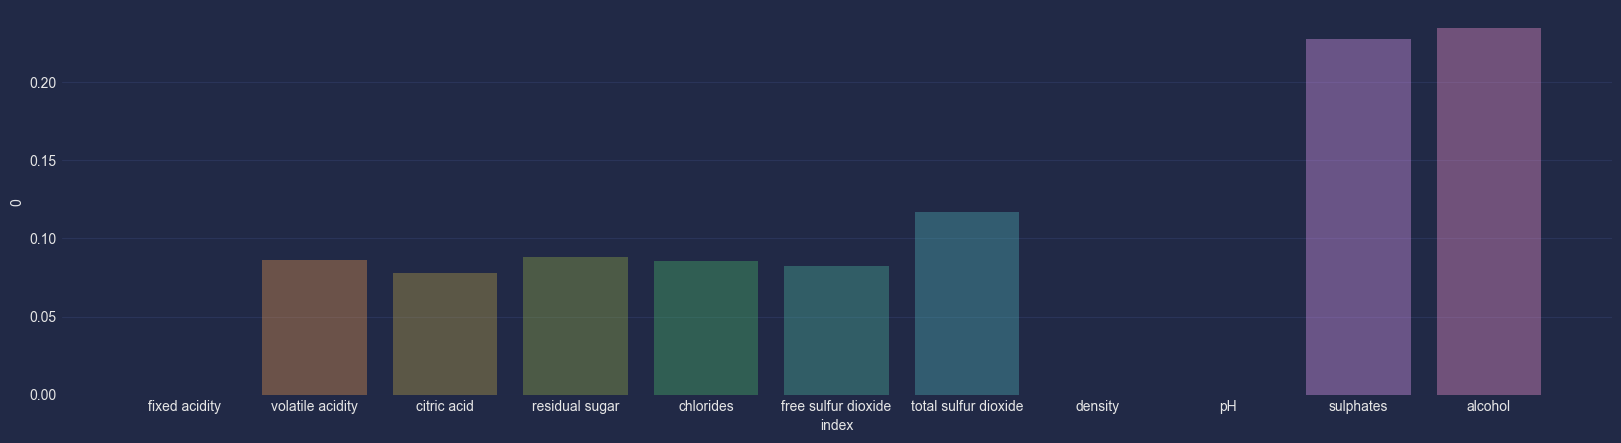

In [440]:
render_xgb_features(model)

In [441]:
fi_df = pd.DataFrame([model.feature_importances_], columns=train_df[features].columns)
fi_df.loc[0].to_dict()

{'fixed acidity': 0.0,
 'volatile acidity': 0.08620231598615646,
 'citric acid': 0.07801324129104614,
 'residual sugar': 0.08802979439496994,
 'chlorides': 0.08570964634418488,
 'free sulfur dioxide': 0.0823662206530571,
 'total sulfur dioxide': 0.11724639683961868,
 'density': 0.0,
 'pH': 0.0,
 'sulphates': 0.22760534286499023,
 'alcohol': 0.23482708632946014}

feature:fixed acidity color#ff0000 row:-1 col0
feature:volatile acidity color#d08b00 row:0 col1
feature:citric acid color#d48000 row:0 col2
feature:residual sugar color#d08e00 row:0 col3
feature:chlorides color#d08b00 row:0 col0
feature:free sulfur dioxide color#d28500 row:1 col1
feature:total sulfur dioxide color#c0be00 row:1 col2
feature:density color#ff0000 row:1 col3
feature:pH color#ff0000 row:1 col0
feature:sulphates color#0b8300 row:2 col1
feature:alcohol color#008000 row:2 col2


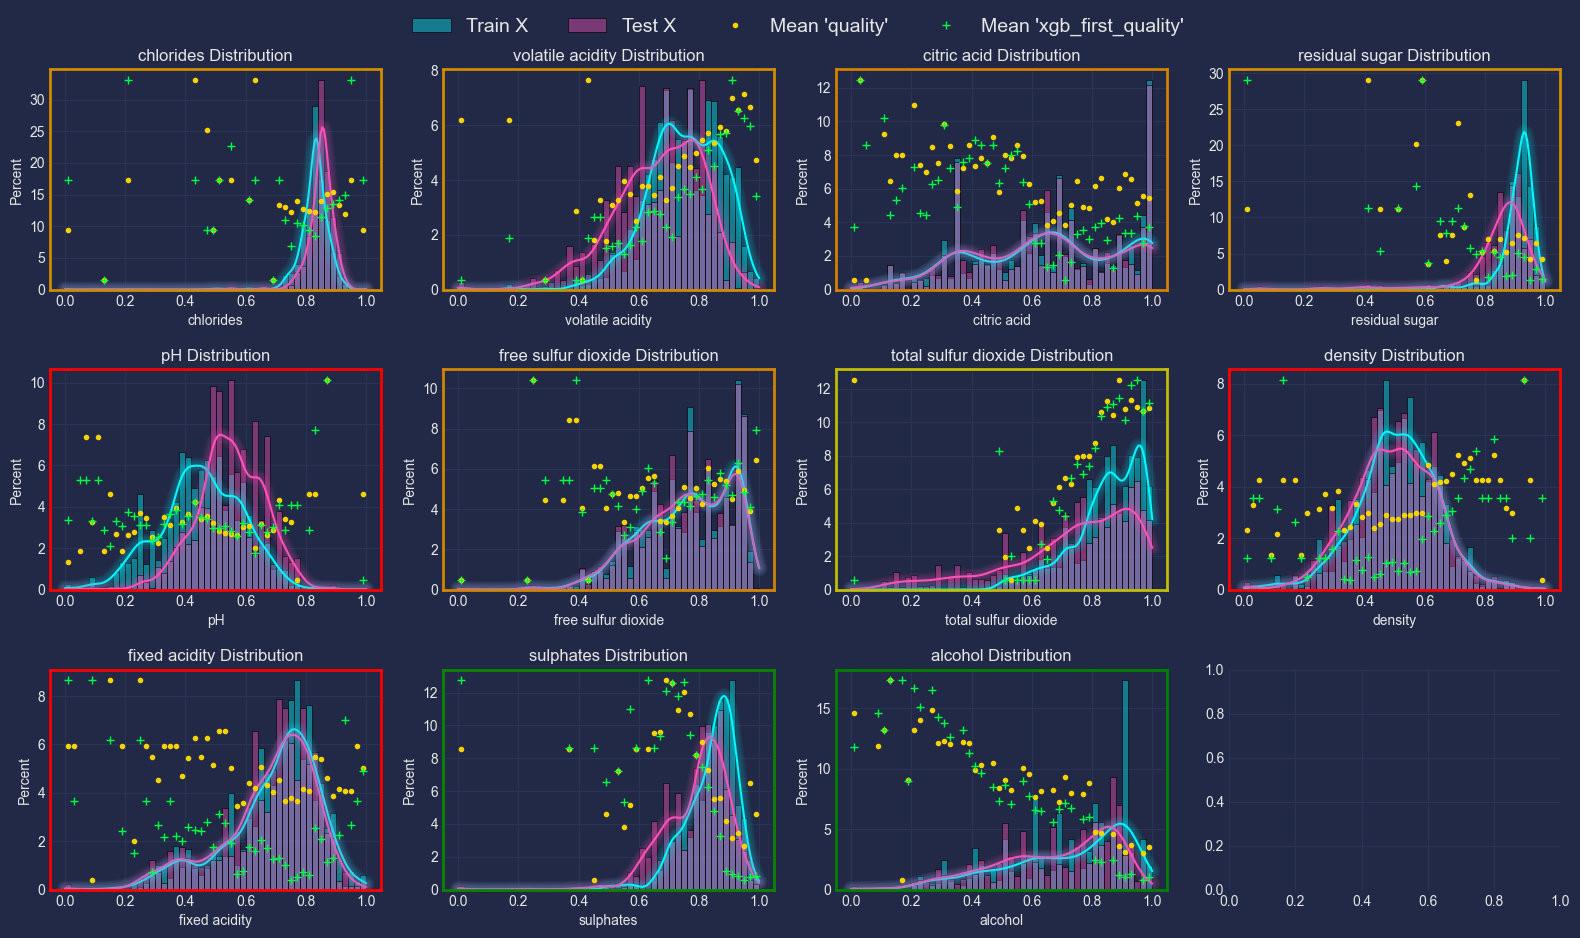

In [442]:
train_df[f'xgb_first_{target[0]}'] = predictions
fi_df = pd.DataFrame([model.feature_importances_], columns=train_df[features].columns)
render_feature_distros(train_df=train_df, test_df=test_df, features=features, labels=[target[0], f'xgb_first_{target[0]}'], boarders=fi_df.loc[0].to_dict())

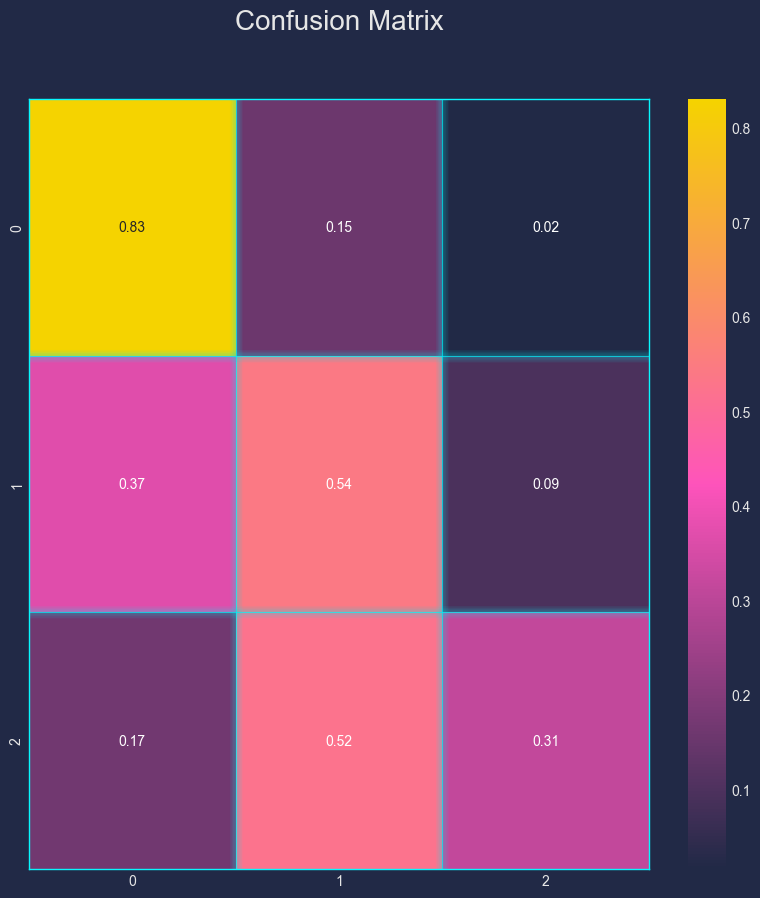

In [443]:
cm = confusion_matrix(train_df[target], predictions, normalize='true')
render_cm(cm)

In [444]:
train_final_preds = model.predict(train_df[features])+3
test_final_preds = model.predict(test_df[features])+3

In [445]:
train_submission = pd.DataFrame(data={'id': train_df.index, target[0]: train_final_preds})
train_submission.to_csv(fr'rendered_data/{objective}_train_submission.csv', index=False)

test_submission = pd.DataFrame(data={'id': test_df.index, target[0]: test_final_preds})
test_submission.to_csv(fr'rendered_data/{objective}_test_submission.csv', index=False)

In [72]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(**static_params, eval_metric=cohen_kappa_score_proxy), param_grid = param_test1, cv=5, verbose=10)

X_train, X_valid, y_train, y_valid = train_test_split(X, train_df[target], test_size=0.20)

gsearch1.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START max_depth=3, min_child_weight=1............................
[0]	validation_0-mlogloss:1.50760	validation_0-cohen_kappa_score_proxy:0.41634
[1]	validation_0-mlogloss:1.35142	validation_0-cohen_kappa_score_proxy:0.48918
[2]	validation_0-mlogloss:1.25343	validation_0-cohen_kappa_score_proxy:0.51248
[3]	validation_0-mlogloss:1.18304	validation_0-cohen_kappa_score_proxy:0.53465
[4]	validation_0-mlogloss:1.13498	validation_0-cohen_kappa_score_proxy:0.51195
[5]	validation_0-mlogloss:1.09822	validation_0-cohen_kappa_score_proxy:0.50587
[6]	validation_0-mlogloss:1.07034	validation_0-cohen_kappa_score_proxy:0.51783
[7]	validation_0-mlogloss:1.04882	validation_0-cohen_kappa_score_proxy:0.50669
[8]	validation_0-mlogloss:1.03407	validation_0-cohen_kappa_score_proxy:0.50793
[9]	validation_0-mlogloss:1.02528	validation_0-cohen_kappa_score_proxy:0.53095
[10]	validation_0-mlogloss:1.01664	validation_0-cohen_kappa_score_pr

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=50,
                                     enable_categorical=False,
                                     eval_metric=<function cohen_kappa_score_proxy at 0x0000014ACD802D40>,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     i...
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None,
                                     objective='multi:softmax', predictor=None, ...),
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             verbose=10)

In [73]:
gsearch1.best_params_

{'max_depth': 3, 'min_child_weight': 3}

In [74]:
gsearch1.best_params_

{'max_depth': 3, 'min_child_weight': 3}

In [75]:
gsearch1.best_score_

0.5950069645344478

In [76]:
gsearch1.__dict__

{'scoring': None,
 'estimator': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=50,
               enable_categorical=False,
               eval_metric=<function cohen_kappa_score_proxy at 0x0000014ACD802D40>,
               feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, n_estimators=100, n_jobs=-1,
               num_parallel_tree=None, objective='multi:softmax', predictor=None, ...),
 'n_jobs': None,
 'refit': True,
 'cv': 5,
 'verbose': 10,
 'pre_dispatch': '2*n_jobs',
 'error_score': nan,
 'return_train_score': Fa

In [81]:
predictions = gsearch1.best_estimator_.predict(train_df[features])
score = cohen_kappa_score_proxy(train_df[target], predictions)
print(score)

0.5030886977370426


In [52]:

static_params.update(gsearch1.best_params_)
print(f'tringing with:{static_params}')
eval_model = xgb.XGBClassifier(**static_params)
X_train, X_valid, y_train, y_valid = train_test_split(X, train_df[target], test_size=0.20)
eval_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
predictions = eval_model.predict(train_df[features])
score = cohen_kappa_score(train_df[target], predictions, weights='quadratic')
print(score)

tringing with:{'tree_method': 'gpu_hist', 'objective': 'multi:softmax', 'seed': 2016, 'n_jobs': -1, 'early_stopping_rounds': 20000, 'max_depth': 3, 'min_child_weight': 1}
0.4726783631800887


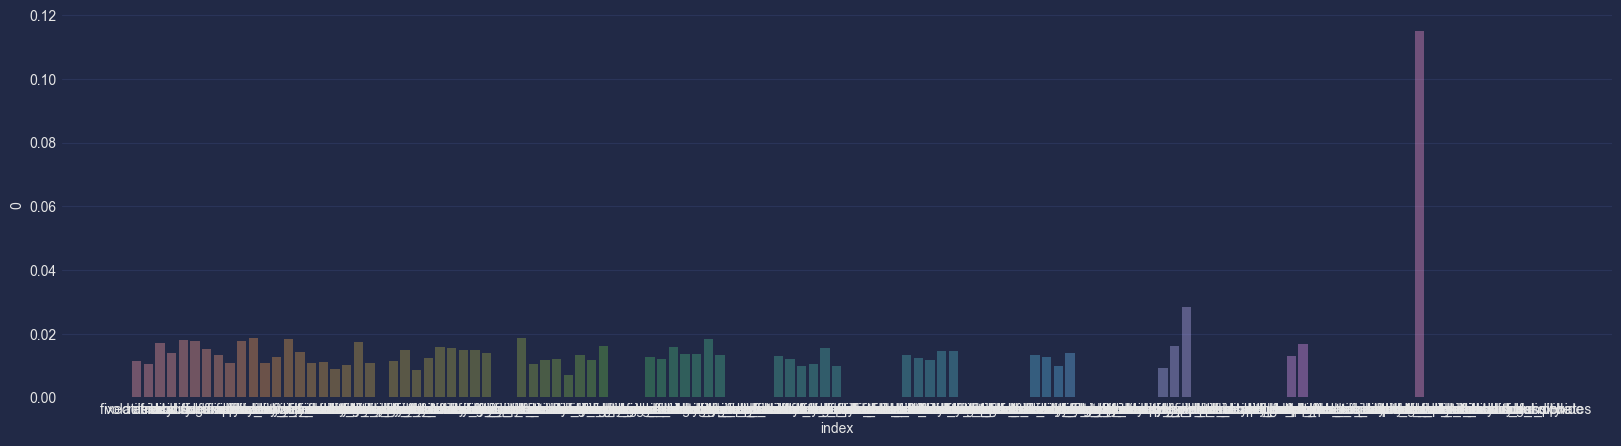

In [53]:
render_xgb_features(model)

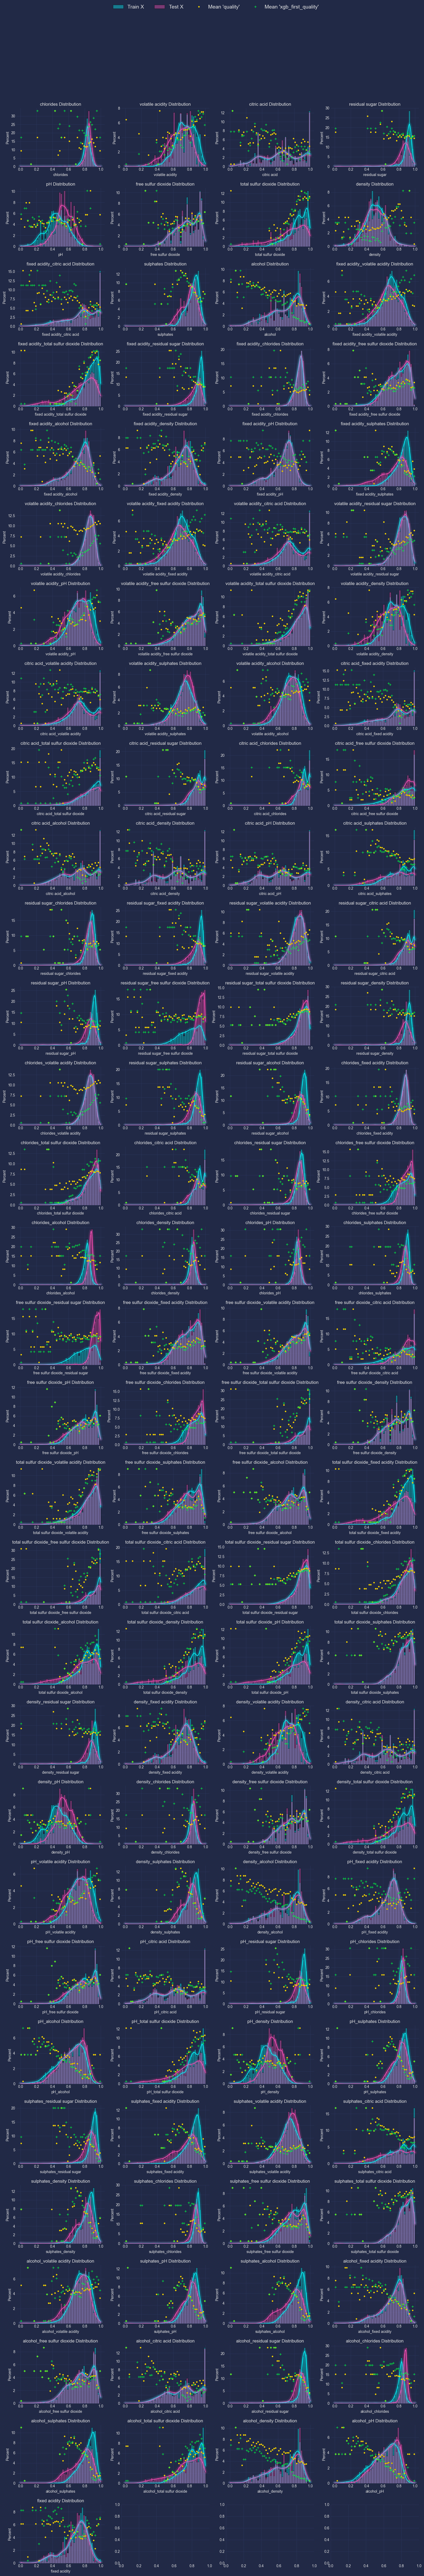

In [54]:
train_df[f'xgb_first_{target[0]}'] = predictions
render_feature_distros(train_df=train_df, test_df=test_df, features=features, labels=[target[0], f'xgb_first_{target[0]}'])

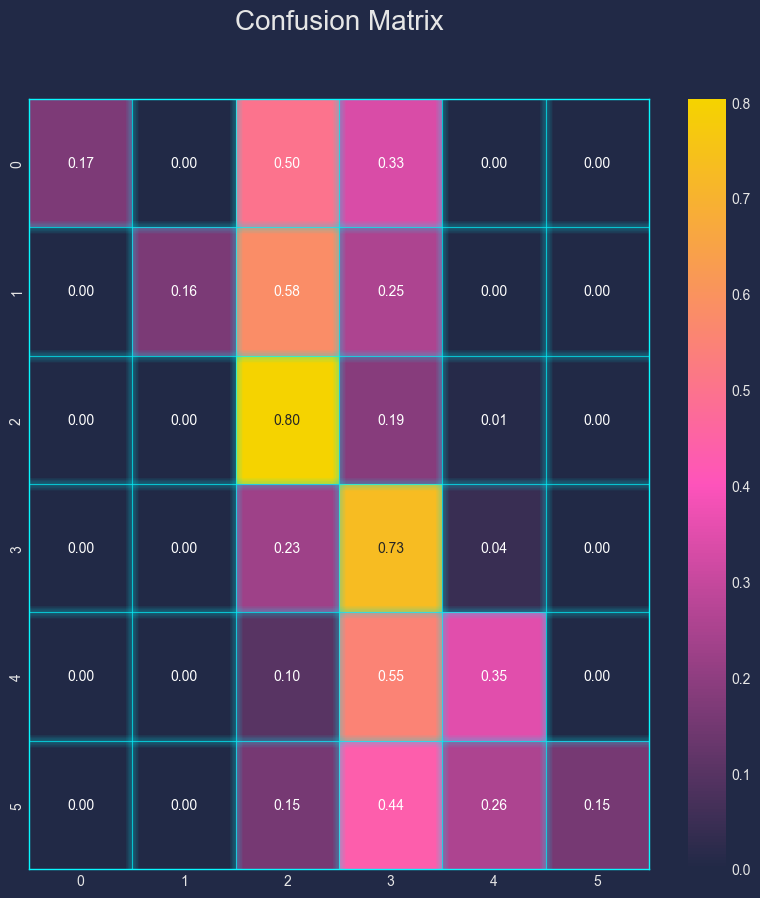

In [55]:
cm = confusion_matrix(train_df[target], predictions, normalize='true')
render_cm(cm)